In [1]:
!pip install -U opencv-python
!apt-get upgrade
!apt update && apt install -y libsm6 libxext6 ffmpeg libfontconfig1 libxrender1 libgl1-mesa-glx
!aws s3 cp s3://lowresolutionhighresolution/dataset/ . --recursive

/bin/sh: apt-get: command not found
/bin/sh: apt: command not found
download: s3://lowresolutionhighresolution/dataset/.DS_Store to ./.DS_Store        
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/10.png to Raw Data/high_res/10.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/1.png to Raw Data/high_res/1.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/0.png to Raw Data/high_res/0.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/101.png to Raw Data/high_res/101.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/105.png to Raw Data/high_res/105.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/103.png to Raw Data/high_res/103.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/100.png to Raw Data/high_res/100.png
download: s3://lowresolutionhighresolution/dataset/Raw Data/high_res/104.png to Raw Data/high_res/104.png
download: 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

print(np.__version__)
print(tf.__version__)
print(cv2.__version__)
!pip install --upgrade tensorflow
!pip install numpy --upgrade

1.18.5
2.1.3
4.5.1
     |███████████████████████▋        | 291.0 MB 162.2 MB/s eta 0:00:01

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



     |████████████████████████████████| 394.3 MB 22 kB/s 
     |████████████████████████████████| 462 kB 86.3 MB/s eta 0:00:01
     |████████████████████████████████| 6.0 MB 86.0 MB/s eta 0:00:01
     |████████████████████████████████| 3.8 MB 74.3 MB/s eta 0:00:01
     |████████████████████████████████| 42 kB 2.6 MB/s s eta 0:00:01
     |████████████████████████████████| 14.8 MB 125.8 MB/s eta 0:00:01
     |████████████████████████████████| 3.9 MB 92.8 MB/s eta 0:00:01
     |████████████████████████████████| 781 kB 90.2 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.18.5
    Uninstalling numpy-1.18.5:
      Successfully uninstalled numpy-1.18.5
  Attempting uninstall: grpcio
    Found existing installation: grpcio 1.36.1
    Uninstalling grpcio-1.36.1:
      Successfully uninstalled grpcio-1.36.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.1.0
    Uninstalling tensorflow-estimator-2.1.0:
 

In [15]:
def load_data(path):
    high_res_images = []
    low_res_images = []
    for dirname, _, filenames in os.walk(path+'high_res'):
        for filename in filenames:
            img = cv2.imread(os.path.join(dirname, filename))
            #img = process_image(img)
            high_res_images.append(img)
        
    for dirname, _, filenames_2 in os.walk(path+'low_res'):
        for filename in filenames_2:
            if filename in filenames: # check for non-present images
                img = cv2.imread(os.path.join(dirname, filename))
                #img = process_image(img)
                low_res_images.append(img)
    
    # zero-mean and zero-center the standard deviations ....
    low_res_array = np.array(low_res_images)
    mean_centered_low_res = (low_res_array - low_res_array.mean())/low_res_array.std()
    
    # zero-mean and zero-center the standard deviations .....
    high_res_array = np.array(high_res_images)
    mean_centered_high_res = (high_res_array - high_res_array.mean())/high_res_array.std()
    
    
    return mean_centered_low_res, mean_centered_high_res

# def process_image(image):
#     return image/255

In [16]:
base_dir = ''
train_x, train_y =  load_data(base_dir+'train/')
val_x, val_y = load_data(base_dir+'val/')

In [17]:
train_x.shape

(684, 256, 256, 3)

In [18]:
train_y.shape

(684, 256, 256, 3)

In [6]:
val_x.shape

(170, 256, 256, 3)

In [7]:
val_y.shape

(170, 256, 256, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


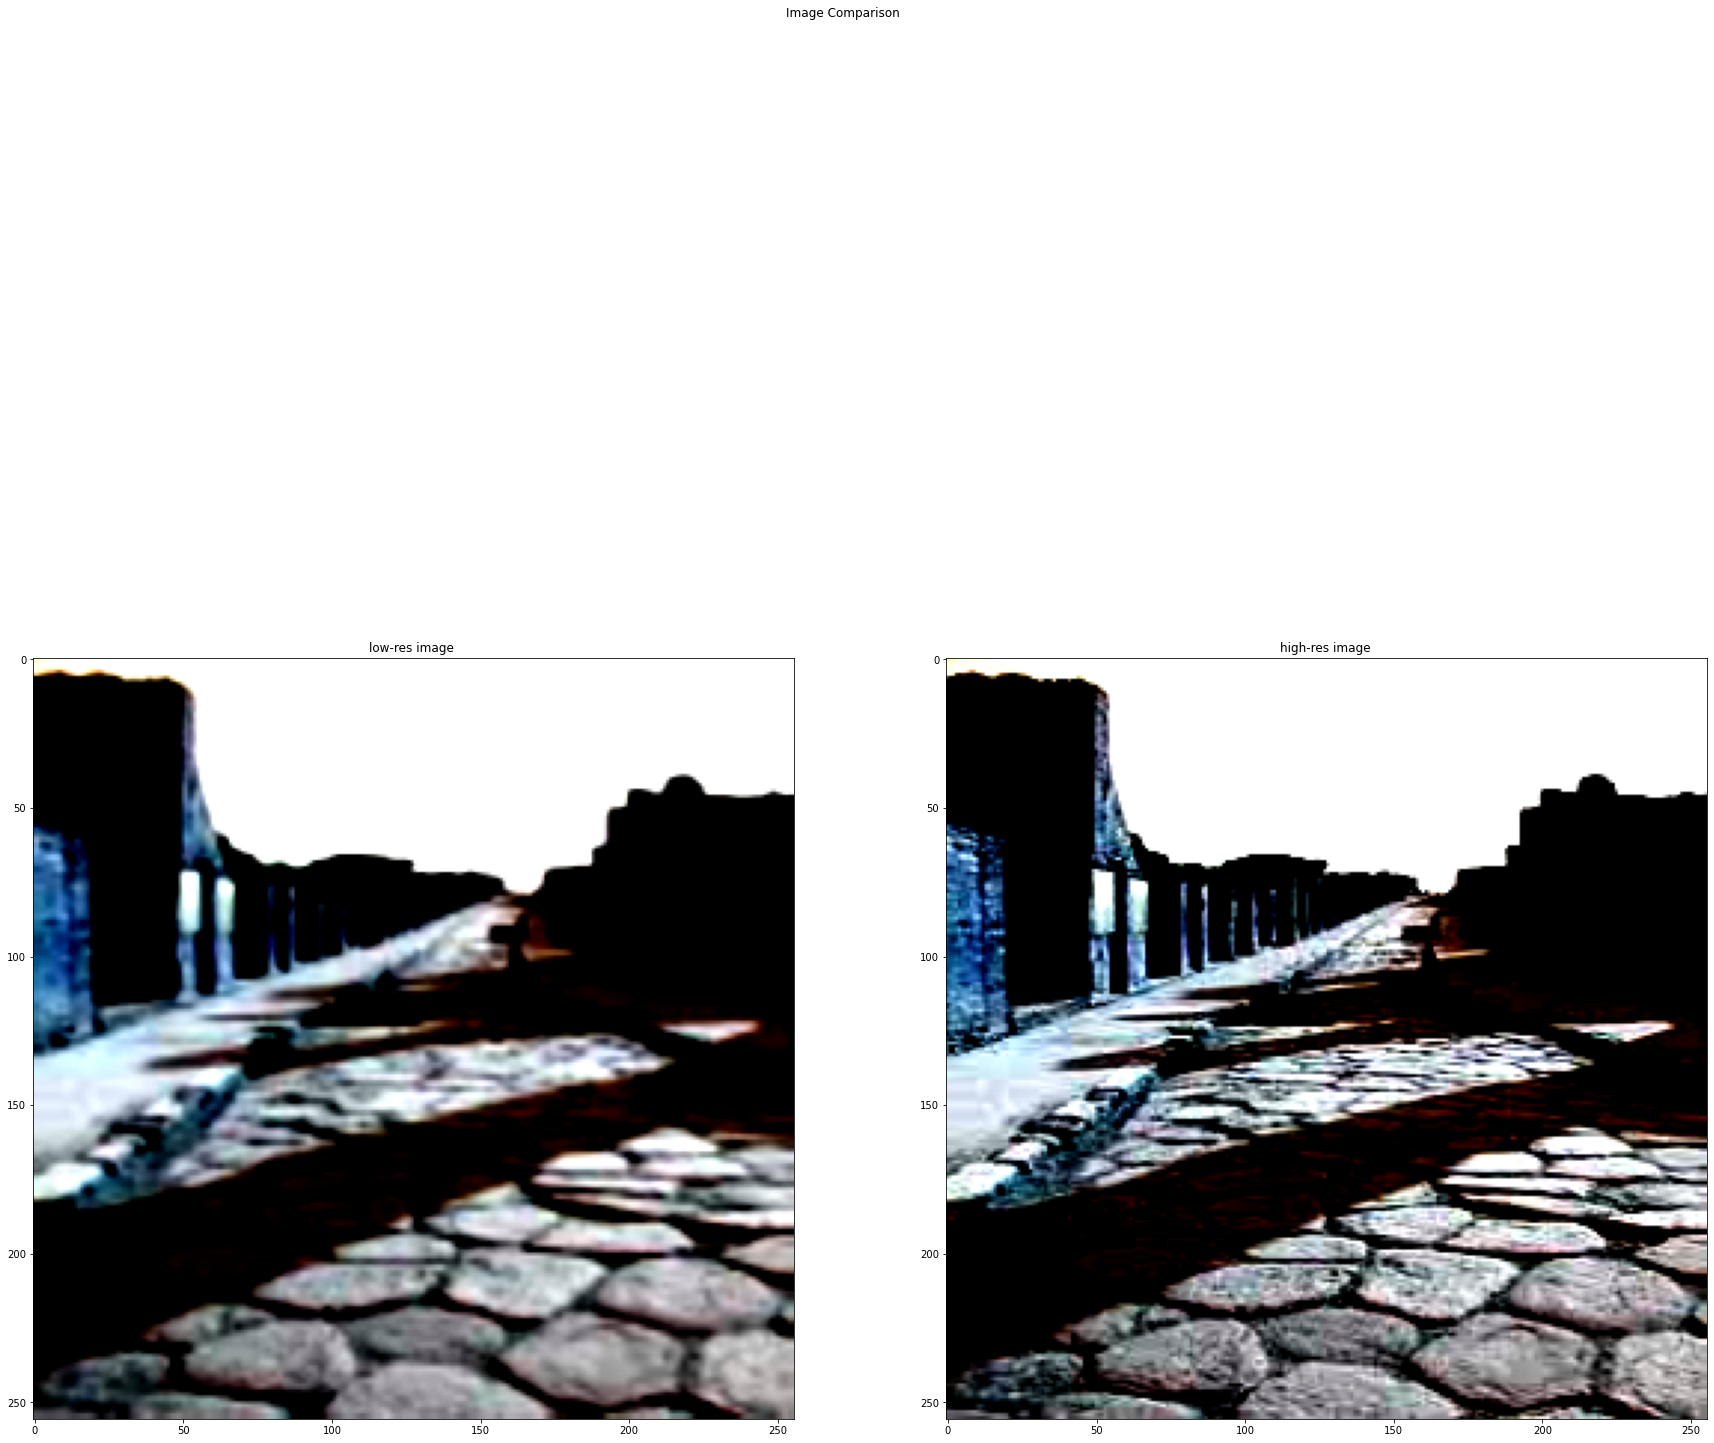

In [19]:
#fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,30))

fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(30,30))
fig.suptitle('Image Comparison')
ax1.imshow(train_x[1])
ax1.title.set_text("low-res image ")
ax2.imshow(train_y[1])
ax2.title.set_text("high-res image ")

In [24]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l1)

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6)
    
    #l8 = UpSampling2D()(l7)
    l8 = Conv2DTranspose(128,(1,1),padding='same',activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l7)

    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    
    #l12 = UpSampling2D()(l11)
    l12 = Conv2DTranspose(128,(2,2),padding='same',activation='relu',bias_initializer='zeros',activity_regularizer=regularizers.l1(10e-10),
                        kernel_initializer=tf.compat.v1.keras.initializers.glorot_normal(seed=None,dtype=tf.dtypes.float32))(l11)
    
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [25]:
#with tf.device('/device:GPU:0'):
model = build_model()
train_x , train_y = train_x , train_y
val_x , val_y = val_x, val_y

ValueError: Operands could not be broadcast together with shapes (128, 128, 128) (64, 64, 128)

In [11]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 36928       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 128, 128, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

In [12]:
def train(train_x, train_y, epochs = 1, batch_size = 10, shuffle = True):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)

In [ ]:
train(train_x, train_y, epochs = 10, batch_size = 10, shuffle = True)

Train on 684 samples
Epoch 1/10
684/684 [==============================] - 141s 207ms/sample - loss: 0.5596
Epoch 2/10
684/684 [==============================] - 139s 204ms/sample - loss: 0.4497
Epoch 3/10
684/684 [==============================] - 139s 203ms/sample - loss: 0.4469
Epoch 4/10
684/684 [==============================] - 140s 204ms/sample - loss: 0.4460
Epoch 5/10
684/684 [==============================] - 140s 204ms/sample - loss: 0.4454
Epoch 6/10
684/684 [==============================] - 139s 204ms/sample - loss: 0.4450
Epoch 7/10
684/684 [==============================] - 139s 204ms/sample - loss: 0.4448
Epoch 8/10
684/684 [==============================] - 139s 203ms/sample - loss: 0.4444
Epoch 9/10
620/684 [==========================>...] - ETA: 13s - loss: 0.4515

In [ ]:
# NEw model utilizing convolution 2D transpose 
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l1)

    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l4)

    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10))(l6)
    
    l8 = UpSampling2D()(l7)

    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l9)

    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10))(l13)

    l15 = add([l14, l2])

    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10))(l15)


    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model



In [34]:
## Generating a NEW architecture with BN and 
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l4)
    l6 = MaxPooling2D(padding='same')(l5)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l6)
    
    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l9)
    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l13)
    l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l15)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [35]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_12[0][0]                  
____________________________________________________________________________________________

In [36]:
def train(train_x, train_y, epochs = 1, batch_size = 24, shuffle = True):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)
train(train_x, train_y, epochs = 10, batch_size = 24, shuffle = True)

Train on 684 samples
Epoch 1/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0017
Epoch 2/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0017
Epoch 3/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0016
Epoch 4/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0016
Epoch 5/10
684/684 [==============================] - 136s 200ms/sample - loss: 0.0016
Epoch 6/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0016
Epoch 7/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0015
Epoch 8/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0015
Epoch 9/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0015
Epoch 10/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0015


In [40]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, UpSampling2D, add, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
import tensorflow as tf

def build_model():
    input_img = Input(shape=(256, 256, 3))
    l1 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.compat.v1.keras.initializers(input_img)
    l2 = Conv2D(64, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l1)
    l3 = MaxPooling2D(padding='same')(l2)
    l3 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l3)
    #l3 = Dropout(0.3)(l3)
    l4 = Conv2D(128, (3, 3),  padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l3)
    l5 = Conv2D(128, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l4)
    l6 = MaxPooling2D(padding='same')(l5)
    l15 = BatchNormalization(axis=-1, momentum=0.9, epsilon=0.001)(l6)
    l7 = Conv2D(256, (3, 3), padding='same', activation='relu', 
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l15)
    
    l8 = UpSampling2D()(l7)
    l9 = Conv2D(128, (3, 3), padding='same', activation='relu',
                activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l8)
    l10 = Conv2D(128, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l9)
    l11 = add([l5, l10])
    l12 = UpSampling2D()(l11)
    l13 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l12)
    l14 = Conv2D(64, (3, 3), padding='same', activation='relu',
                 activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l13)
    l15 = add([l14, l2])
    decoded = Conv2D(3, (3, 3), padding='same', activation='relu', 
                     activity_regularizer=regularizers.l1(10e-10),kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False))(l15)
    model = Model(input_img, decoded)
    model.compile(optimizer='adam', loss='mean_squared_error')
    #model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [38]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_11 (Conv2D)              (None, 256, 256, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
conv2d_12 (Conv2D)              (None, 256, 256, 64) 36928       conv2d_11[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_12[0][0]                  
____________________________________________________________________________________________

In [41]:
#with tf.device('/device:GPU:0'):
model = build_model()
#train_x , train_y = train_x , train_y
#val_x , val_y = val_x, val_y

AttributeError: module 'tensorflow' has no attribute 'contrib'

In [39]:
def train(train_x, train_y, epochs = 1, batch_size = 24, shuffle = True):
    model.fit(train_x, train_y,epochs= epochs,batch_size=batch_size,shuffle=shuffle)
train(train_x, train_y, epochs = 10, batch_size = 24, shuffle = True)

Train on 684 samples
Epoch 1/10
684/684 [==============================] - 137s 200ms/sample - loss: 0.0014
Epoch 2/10
684/684 [==============================] - 136s 198ms/sample - loss: 0.0014
Epoch 3/10
684/684 [==============================] - 136s 199ms/sample - loss: 0.0014
Epoch 4/10
384/684 [===============>..............] - ETA: 1:00 - loss: 0.0014

KeyboardInterrupt: 